# Objective: #

Segment customers based on their purchasing behavior (e.g., using RFM - Recency, Frequency, Monetary Value) to enable targeted marketing campaigns and personalized offers.

In [1]:
# import liabraries for customer sementation based on RFM
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
# import libraries for clustering
from sklearn.cluster import KMeans
# import libraries for data preprocessing
from sklearn.preprocessing import StandardScaler
# import libraries for evaluation
from sklearn.metrics import silhouette_score, davies_bouldin_score
# import libraries for saving and loading models
import joblib

# Data Loading and Preparation: #

In [2]:
# Load customer transaction data.
df = pd.read_csv('D:\internship\customer_segmentation\data\customer_transactions_mock_data.csv')   


In [3]:
# Convert date columns to datetime objects.
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])


In [4]:
# basic information bout data
def basic_eda(df):
    print("Data Shape:", df.shape)
    print("Data Types:\n", df.dtypes)
    print("Missing Values:\n", df.isnull().sum())
    print("Sample Data:\n", df.head())
    print("Descriptive Statistics:\n", df.describe())
    print("Unique Customers:", df['CustomerID'].nunique())
    print("Total Transactions:", len(df))
basic_eda(df)


Data Shape: (15143, 7)
Data Types:
 TransactionID              object
CustomerID                 object
TransactionDate    datetime64[ns]
ProductID                  object
Quantity                    int64
UnitPrice                 float64
TotalPrice                float64
dtype: object
Missing Values:
 TransactionID      0
CustomerID         0
TransactionDate    0
ProductID          0
Quantity           0
UnitPrice          0
TotalPrice         0
dtype: int64
Sample Data:
   TransactionID CustomerID TransactionDate ProductID  Quantity  UnitPrice  \
0    TRX50000_0   CUST1302      2022-01-12  Prod_107         3      53.74   
1    TRX50000_1   CUST1302      2022-01-12  Prod_104         2      43.15   
2    TRX50000_2   CUST1302      2022-01-12  Prod_107         1      59.80   
3    TRX50001_0   CUST1267      2023-10-17  Prod_108         1     214.31   
4    TRX50001_1   CUST1267      2023-10-17  Prod_109         3     312.02   

   TotalPrice  
0      161.22  
1       86.30  
2       59

No missing values and duplicates are found in data.

In [5]:
df.head()

,TransactionID,CustomerID,TransactionDate,ProductID,Quantity,UnitPrice,TotalPrice
0,TRX50000_0,CUST1302,2022-01-12,Prod_107,3,53.74,161.22
1,TRX50000_1,CUST1302,2022-01-12,Prod_104,2,43.15,86.30
2,TRX50000_2,CUST1302,2022-01-12,Prod_107,1,59.80,59.80
3,TRX50001_0,CUST1267,2023-10-17,Prod_108,1,214.31,214.31
4,TRX50001_1,CUST1267,2023-10-17,Prod_109,3,312.02,936.06


# RFM Analysis (or other behavioral features): #

In [32]:
# Determine a snapshot date (one day after the latest transaction date in the dataset)
snapshot_date = df['TransactionDate'].max() + pd.Timedelta(days=1)
print(f"\nSnapshot Date for RFM analysis: {snapshot_date.date()}")


Snapshot Date for RFM analysis: 2023-12-31


In [31]:
# Calculate RFM values
rfm_df = df.groupby('CustomerID').agg(
    Recency=('TransactionDate', lambda date: (snapshot_date - date.max()).days),
    Frequency=('TransactionDate', 'count'), # Count of transactions for each customer
    Monetary=('TotalPrice', 'sum') # Sum of purchase amounts for each customer
).reset_index()

# Display RFM DataFrame head
print("\nRFM DataFrame Head")
print(rfm_df.head())



RFM DataFrame Head
  CustomerID  Recency  Frequency  Monetary
0   CUST1000        9         41   6855.79
1   CUST1001       49         10   2856.43
2   CUST1002        7         25   2175.73
3   CUST1003       22         33   1085.57
4   CUST1004      134         27   6887.81


# Exploratory Data Analysis and Feature Scaling: #

In [30]:
print("\nRFM Statistics")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].describe())


RFM Statistics
          Recency   Frequency    Monetary
count  500.000000  500.000000    500.0000
mean    71.310000   30.286000   6279.1636
std     65.035075   10.224543   4430.0027
min      1.000000    4.000000    377.0000
25%     22.000000   23.000000   2579.4425
50%     54.000000   30.000000   5292.9750
75%    105.250000   37.000000   9319.3500
max    500.000000   57.000000  20453.5000


In [29]:
# Check for skewness
print("\nRFM Skewness")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].skew())



RFM Skewness
Recency      1.647826
Frequency    0.207320
Monetary     0.790106
dtype: float64


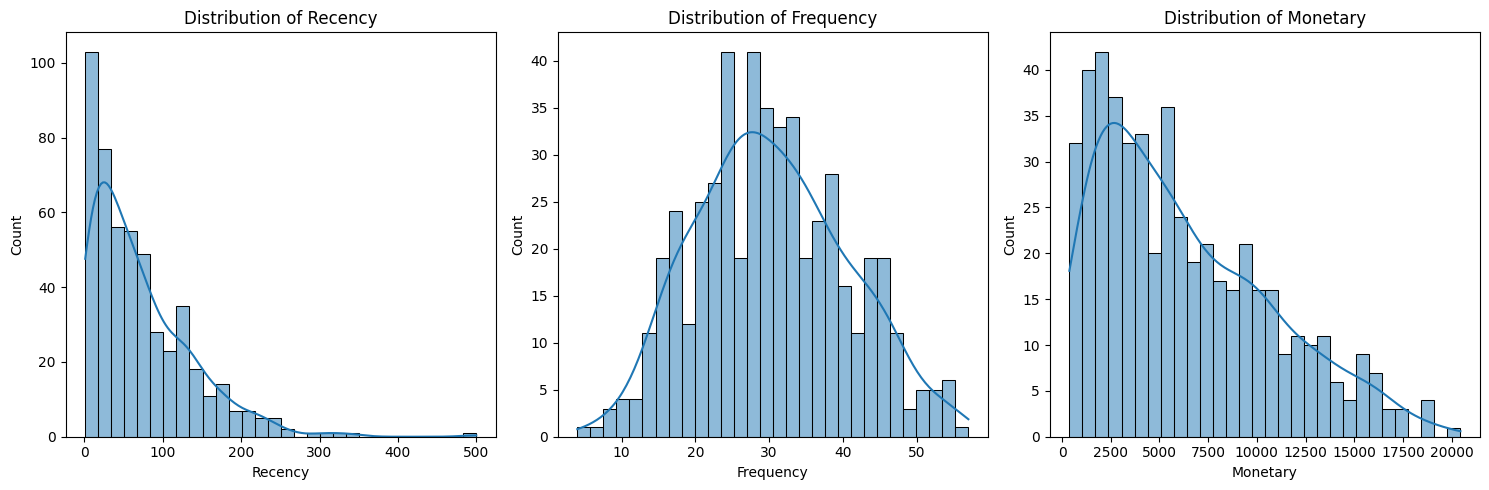

In [10]:
# Visualize the distributions before transformation
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], bins=30, kde=True)
plt.title('Distribution of Recency')
plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], bins=30, kde=True)
plt.title('Distribution of Frequency')
plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], bins=30, kde=True)
plt.title('Distribution of Monetary')
plt.tight_layout()

In [28]:
# Apply log transformation (using log1p to handle zeros, if any, and reduce skewness)
rfm_log_transformed = rfm_df.copy()
for col in ['Recency', 'Frequency', 'Monetary']:
    # Add a small constant or ensure values are non-negative for log transformation if needed.
    # Recency usually starts from 0, Frequency/Monetary can be 0 for some customer, but usually not in this context.
    # np.log1p(x) computes log(1+x), which is good for values starting from 0.
    rfm_log_transformed[col] = np.log1p(rfm_log_transformed[col])

print("\nSkewness of Log-Transformed RFM Features")
print(rfm_log_transformed[['Recency', 'Frequency', 'Monetary']].skew())



Skewness of Log-Transformed RFM Features
Recency     -0.693848
Frequency   -0.805187
Monetary    -0.579559
dtype: float64


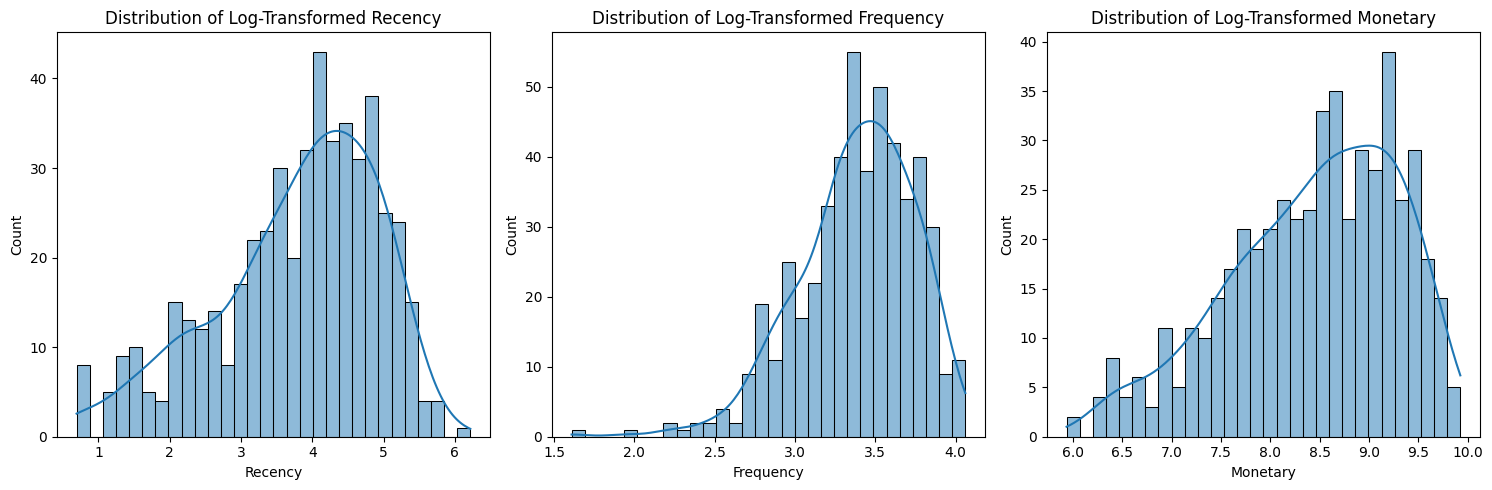

In [12]:
# Visualize the distributions after transformation
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm_log_transformed['Recency'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Recency')
plt.subplot(1, 3, 2)
sns.histplot(rfm_log_transformed['Frequency'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Frequency')
plt.subplot(1, 3, 3)
sns.histplot(rfm_log_transformed['Monetary'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Monetary')
plt.tight_layout()


# Feature Scaling #

In [26]:
# Feature Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log_transformed[['Recency', 'Frequency', 'Monetary']])
df_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
# Keep CustomerID for merging later
df_scaled['CustomerID'] = rfm_log_transformed['CustomerID']
print("\nScaled RFM Data")
print(df_scaled .head())


Scaled RFM Data
    Recency  Frequency  Monetary CustomerID
0 -1.311601   0.980667  0.458701   CUST1000
1  0.107585  -2.729292 -0.562686   CUST1001
2 -1.508367  -0.347315 -0.880192   CUST1002
3 -0.577150   0.395533 -1.690935   CUST1003
4  0.983425  -0.142103  0.464138   CUST1004


# Clustering: #

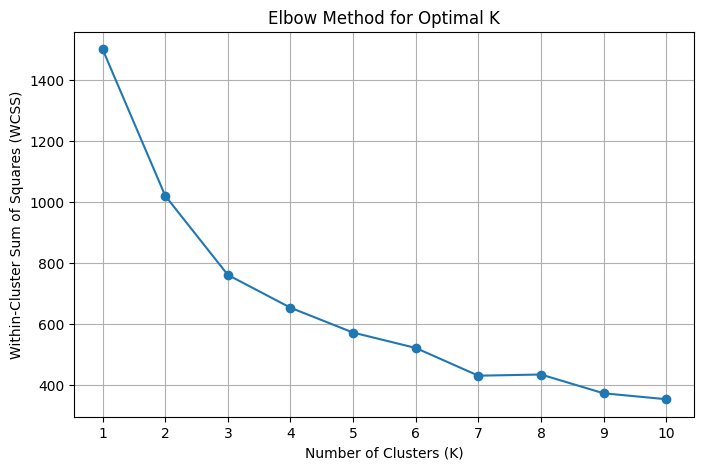

In [37]:
# Clustering (K-Means)
# Determine optimal number of clusters using Elbow Method
def optimal_k_elbow_method(data, max_k=10):
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data[['Recency', 'Frequency', 'Monetary']])
        wcss.append(kmeans.inertia_)
    
    # Plot the Elbow Method
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k + 1), wcss, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.xticks(range(1, max_k + 1))
    plt.grid(True)
    plt.show()

optimal_k_elbow_method(df_scaled)

### Based on the elbow plot, visually choose an optimal k. Let's assume k=4 is a good starting point.

In [36]:
# Apply K-Means clustering with the chosen optimal_k
# Based on the elbow method, let's assume we choose k=4 for clustering.
optimal_k = 4
def kmeans_clustering(data, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['Cluster'] = kmeans.fit_predict(data[['Recency', 'Frequency', 'Monetary']])
    return data, kmeans
# Perform K-Means clustering
rfm_clustered, kmeans_model = kmeans_clustering(df_scaled)
# Save the K-Means model
joblib.dump(kmeans_model, 'kmeans_model.pkl')


['kmeans_model.pkl']

# Segment Profiling and Interpretation: #

In [42]:
def profile_segments(rfm, clusters, segment_map=None):
    """
    Assigns cluster labels to the RFM dataframe, summarizes each cluster,
    and maps clusters to segment names.

    Parameters:
        rfm (pd.DataFrame): DataFrame containing RFM metrics.
        clusters (array-like): Cluster labels for each customer.
        segment_map (dict, optional): Mapping from cluster label to segment name.

    Returns:
        rfm (pd.DataFrame): Updated DataFrame with 'Cluster' and 'Segment' columns.
        cluster_summary (pd.DataFrame): Summary statistics by cluster.
    """
    # Assign clusters
    rfm = rfm.copy()
    rfm['Cluster'] = clusters

    # Cluster summary
    cluster_summary = rfm.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(2)

    # Default segment map if not provided
    if segment_map is None:
        segment_map = {
            0: "At-Risk Customers",
            1: "Loyal High Spenders", 
            2: "New Customers",
            3: "Potential Churners"
        }

    # Map cluster labels to segment names
    rfm['Segment'] = rfm['Cluster'].map(segment_map)

    return rfm, cluster_summary

# Profile segments
rfm_segmented, cluster_summary = profile_segments(rfm_clustered, rfm_clustered['Cluster'])

# Display the cluster summary
print("\nCluster Summary")
print(cluster_summary)




Cluster Summary
        Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         -0.37     -0.20    -1.30   103
1          0.47      0.54     0.60   212
2         -1.42      0.37     0.55    91
3          0.72     -1.37    -0.47    94


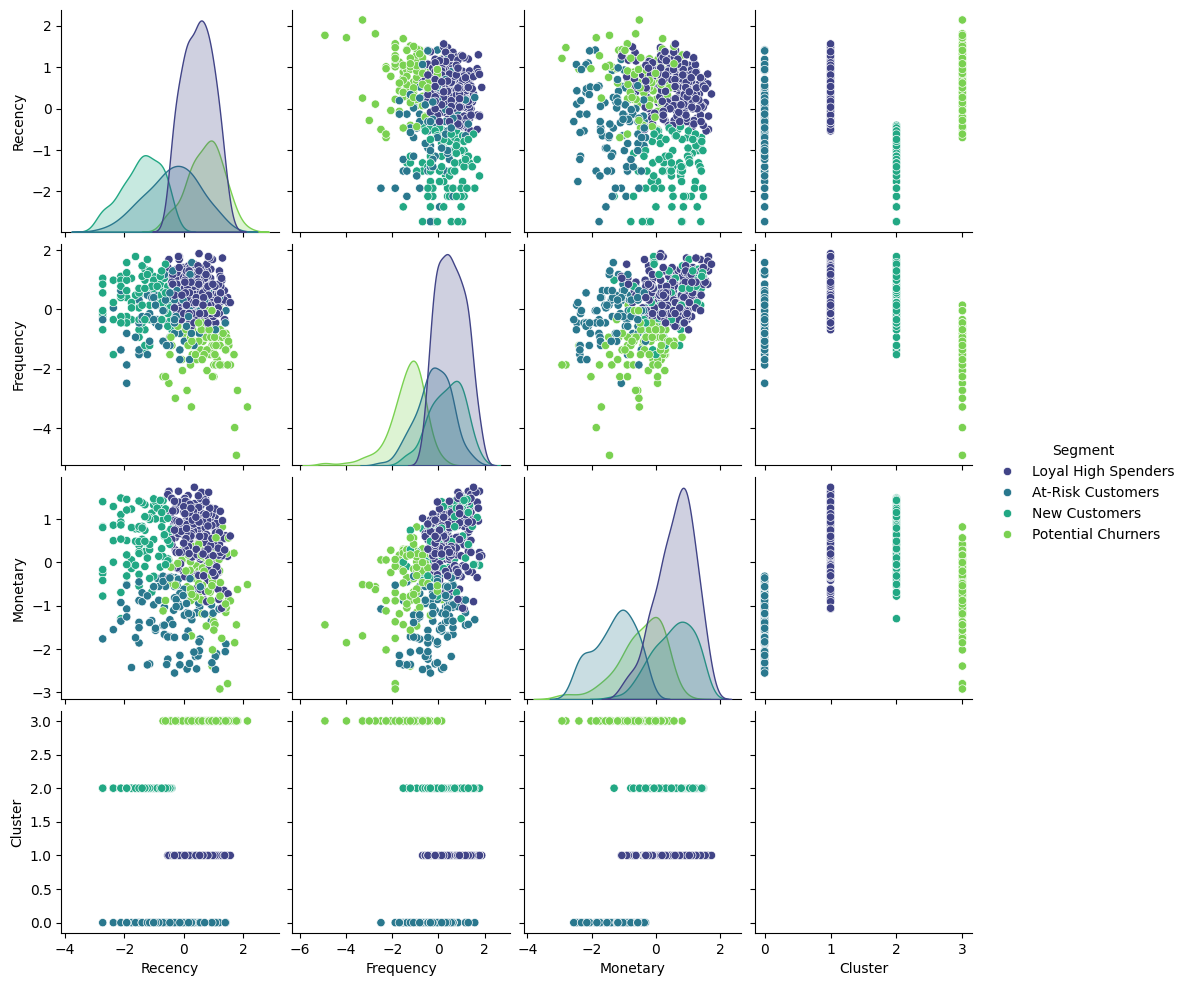

In [ ]:
# Visualization of RFM Segments
# Define your segment order and corresponding colors
segment_order = [
    "Loyal High Spenders",
    "At-Risk Customers",
    "New Customers",
    "Potential Churners"
]

# Choose a color palette (e.g., seaborn's 'viridis' or custom colors)
palette = sns.color_palette("viridis", n_colors=len(segment_order))
segment_color_map = dict(zip(segment_order, palette))

# Pairplot: RFM Features by Segment 

sns.pairplot(
    rfm_segmented,
    hue='Segment',
    palette=segment_color_map,
    hue_order=segment_order
)
plt.show()



In [ ]:
# Evaluate clustering performance
def evaluate_clustering(data, clusters):
    """
    Evaluates clustering performance using silhouette score and Davies-Bouldin index.

    Parameters:
        data (pd.DataFrame): DataFrame containing RFM metrics.
        clusters (array-like): Cluster labels for each customer.

    Returns:
        silhouette (float): Silhouette score.
        davies_bouldin (float): Davies-Bouldin index.
    """
    silhouette = silhouette_score(data[['Recency', 'Frequency', 'Monetary']], clusters)
    davies_bouldin = davies_bouldin_score(data[['Recency', 'Frequency', 'Monetary']], clusters)
    return silhouette, davies_bouldin

# Evaluate clustering performance
silhouette, davies_bouldin = evaluate_clustering(rfm_segmented, rfm_segmented['Cluster'])
print("\n--- Clustering Evaluation ---")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

# Save the model and scaler
joblib.dump(kmeans_model, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


--- Clustering Evaluation ---
Silhouette Score: 0.2862
Davies-Bouldin Index: 1.1764


['scaler.pkl']


### Silhouette Score: 0.2862 ###

The Silhouette Score measures how similar each data point is to its own cluster compared to other clusters.

Interpretation:

Your score of 0.2862 suggests that the clusters are moderately well separated, but there is some overlap or ambiguity in cluster boundaries. In practical terms, this is a fair result for real-world customer data, which often has overlapping behaviors.

### Davies-Bouldin Index: 1.1764 ###

The Davies-Bouldin Index evaluates the average similarity between each cluster and its most similar one, considering both the distance between clusters and the spread within each cluster.

Interpretation:

Your index of 1.1764 indicates reasonably good clustering. It means that, on average, clusters are distinct but not perfectly separated. For many business datasets, values between 1 and 2 are common and generally acceptable.

Conclusion:

Both metrics suggest your clustering is meaningful, but there may be room for improvement. You could experiment with different numbers of clusters, feature transformations, or alternative algorithms to see if these scores improve.



In [43]:
# Analyze the characteristics of each segment by examining the average RFM values (other demographics if available)
def analyze_segments(rfm):
    """
    Analyzes the characteristics of each segment by calculating average RFM values.

    Parameters:
        rfm (pd.DataFrame): DataFrame containing RFM metrics and segments.

    Returns:
        segment_analysis (pd.DataFrame): Average RFM values for each segment.
    """
    segment_analysis = rfm.groupby('Segment').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'CustomerID': 'count'
    }).rename(columns={'CustomerID': 'Customer Count'}).reset_index()
    
    return segment_analysis
# Analyze segments
segment_analysis = analyze_segments(rfm_segmented)
# Display segment analysis
print("\nSegment Analysis")
print(segment_analysis)




Segment Analysis
               Segment   Recency  Frequency  Monetary  Customer Count
0    At-Risk Customers -0.369412  -0.196027 -1.298159             103
1  Loyal High Spenders  0.469626   0.544693  0.601425             212
2        New Customers -1.420011   0.366508  0.548909              91
3   Potential Churners  0.720316  -1.368472 -0.465345              94


C:\Users\OceanComputers\AppData\Local\Temp\ipykernel_5928\1164269179.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


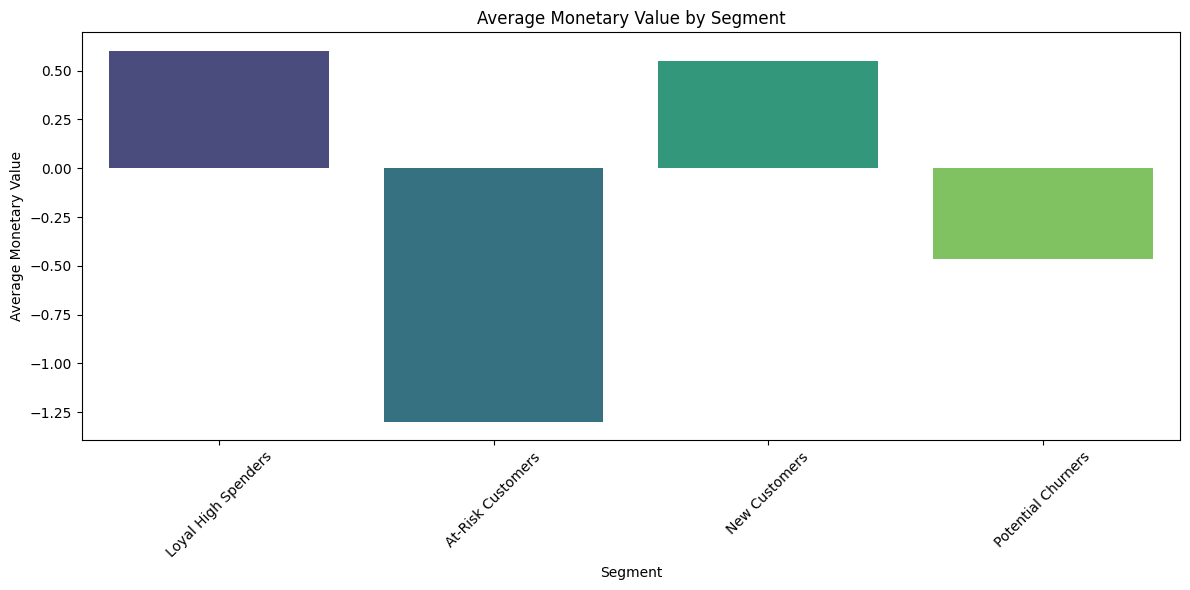

In [44]:
# --- Barplot: Average Monetary Value by Segment ---
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Segment',
    y='Monetary',
    data=segment_analysis,
    order=segment_order,
    palette=segment_color_map
)
plt.title('Average Monetary Value by Segment')
plt.xlabel('Segment')
plt.ylabel('Average Monetary Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\OceanComputers\AppData\Local\Temp\ipykernel_5928\2261242937.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


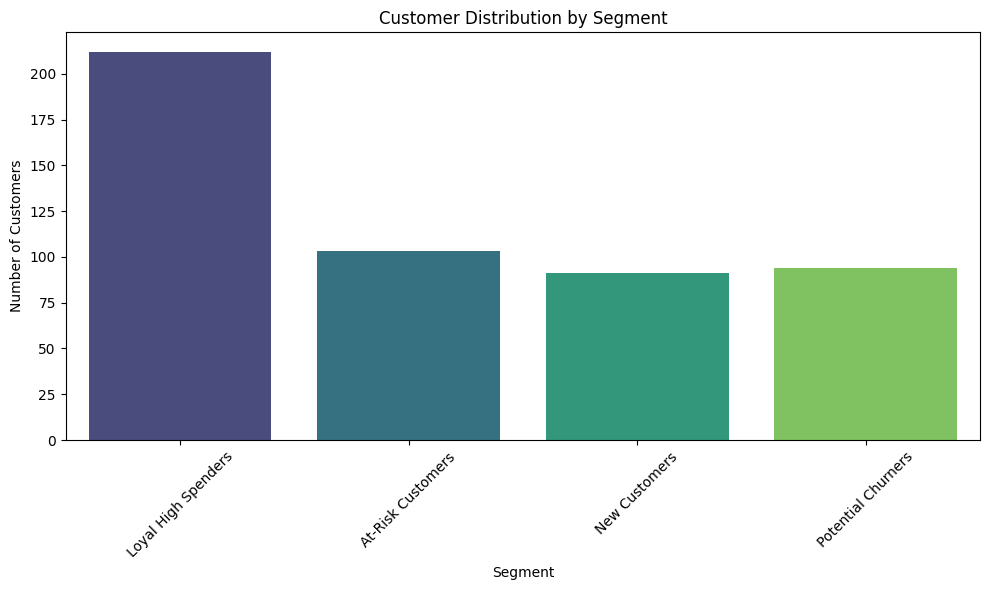

In [46]:
# --- Countplot: Customer Distribution by Segment ---
plt.figure(figsize=(10, 6))
sns.countplot(
    x='Segment',
    data=rfm_segmented,
    order=segment_order,
    palette=segment_color_map
)
plt.title('Customer Distribution by Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [38]:
# Display the final RFM DataFrame with segments
print("\nFinal RFM DataFrame with Segments")
print(rfm_segmented.head())
# Save the final RFM DataFrame with segments to a CSV file
rfm_segmented.to_csv('rfm_segmented.csv', index=False)
# Save the segment analysis to a CSV file
segment_analysis.to_csv('segment_analysis.csv', index=False)
# Save the final RFM DataFrame with segments to a pickle file
rfm_segmented.to_pickle('rfm_segmented.pkl')
# Save the segment analysis to a pickle file
segment_analysis.to_pickle('segment_analysis.pkl')





Final RFM DataFrame with Segments
    Recency  Frequency  Monetary CustomerID  Cluster              Segment
0 -1.311601   0.980667  0.458701   CUST1000        2        New Customers
1  0.107585  -2.729292 -0.562686   CUST1001        3   Potential Churners
2 -1.508367  -0.347315 -0.880192   CUST1002        0    At-Risk Customers
3 -0.577150   0.395533 -1.690935   CUST1003        0    At-Risk Customers
4  0.983425  -0.142103  0.464138   CUST1004        1  Loyal High Spenders
